# Instructions and submission guidelines

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in text (markdown) blocks, and wet questions in code blocks.
* Submission guidelines:
    * Add a text block in the beginning of your notebook with your IDs.
    * When you're done, restart the notebook and make sure that everything runs smoothly (Runtime->"Restart and Run All")
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * If you need to attach additional files to your submission (e.g images), add them to a zip file together with the notebook ipynb file.
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Monday 21/11/2022, 23:59
* For any questions regarding this workshop task, contact [Eden](mailto:edens@campus.technion.ac.il).


<center>
<div>Machine Learning and Human Behavior - 236608 - Winter 2022-2023</div>
<h1>Workshop #1 - Binary Choice ⚖️</h1>
</center>

Dorin Shteyman  - 206721102

Hannen Naarany  - 324045335

# Introduction


In the binary choice setting, users $u\in U$ make a binary decision of whether or not to consume items $x \in X$. Each item is represented by a vector $x\in\mathbb{R}^n$, and the outcome is represented using binary variable $y\in\left\{0,1\right\}$, such that $y=1$ when the item was consumed. 

Given a predicate such as $x\ge 0$, we denote its corresponding indicator function by $\mathbb{1}(x\ge 0)\in\{0,1\}$.

## Abstract population models 

For the implementation of behavioral models, we define the abstract classes which handle data generation and formatting. These are similar to the abstract classes defined in HW1.

As we will mostly use these classes through their public interface, there is no need to go through the implementation in detail.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import sklearn.metrics
import sklearn.linear_model
import sklearn.metrics

from tqdm.auto import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 8
    observations_per_user = 10
    train_user_proportion = 0.6

    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        """
        return np.random.normal(
            loc=1,
            scale=0.1,
            size=(
                n_users,
                self.n_features,
            ),
        )
    
    def _generate_item_attributes(self, n_users):
        """
        Generate latent parameters for items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        items : ndarray of shape
                (n_users, observations_per_user, n_features)
        """
        return np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.n_features,
            ),
        )

    def _choice(self, users, items):
        """
        Discrete choice function
        
        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError
    
    def _generate_choice_dataset(self, n_users):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users = self._generate_user_attributes(n_users)
        items = self._generate_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = f'{i}'
                for k in range(self.n_features):
                        dct[f'x_{k}'] = items[i,j,k]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df
    
    def generate_train_eval_datasets(self, n_users):
        n_train_users = int(n_users*self.train_user_proportion)
        n_test_users = n_users - n_train_users
        return (
            self._generate_choice_dataset(n_train_users),
            self._generate_choice_dataset(n_test_users),
        )

    def get_feature_columns(self):
        return [
            f'x_{k}'
            for k in range(self.n_features)
        ]


class InnerProductTrueValueEnvironment(DiscreteChoiceEnvironment):
    @staticmethod
    def _true_value(users, items):
        # true_value is an inner product u@x.
        # Calculate using np.einsum, where:
        # * i: user index
        # * j: observation (item) index
        # * k: feature
        true_value = np.einsum('ik,ijk->ij', users, items)
        return true_value


# Task \#1: Prediction with stated and revealed preferences


## Introduction

In our first task, we will investigate the relation between predictive performance, and the type of feedback obtained from users.

We assume that consumption decisions are made according to the a random utility model. Each user is represented by a vector $u\in\mathbb{R}^d$, and each item is represented by a vector $x\in\mathbb{R}^d$. The true utility experienced by user $u$ from consuming item $x$ is assumed to be the inner product $v_u(x)=u^Tx$.

We distinguish between three types of feedback:

* **Rational preference**: When user $u$ is queried in an ideal environment, they consume the item if its utility is larger than zero. Their rational choice is to consume if the utility is larger than zero, hence $y_\mathrm{rational} = \mathbb{1}(v_u(x) \ge 0)$.

* **Stated preference**: When user $u$ is questioned explicitly about item $x$ (e.g in a survey), they tend to under-estimate the value of the item. Therefore, their stated consumption choice is given by $y_\mathrm{stated} = \mathbb{1}(v_u(x)-b \ge 0)$, where $b\ge 0$ is a fixed and latent bias term.

* **Revealed preference**: When $u$ is presented with item item $x$, they reply according to a noisy evaluation $y_\mathrm{revealed} = \mathbb{1}(v_u(x)+\varepsilon \ge 0)$, where $\varepsilon\sim N(0,\sigma)$.



## Exercise 1.1: Simulating user behavior

The `NoisyBinaryChoiceEnvironment` class will be used for generating the datasets. It provides a simple interface which will be useful for simulation.



In [ ]:
class NoisyBinaryChoiceEnvironment(InnerProductTrueValueEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def __init__(self, noise_scale, bias=1):
        self.noise_scale = noise_scale
        self.bias = bias

    def _choice(self, users, items):
        true_value = self._true_value(users, items)
        decision_noise = np.random.normal(
            size=true_value.shape,
            scale=self.noise_scale,
        )
        stated_value = true_value-self.bias
        perceived_value = true_value + decision_noise
        return {
            'true_value': true_value,
            'rational_choice': true_value >= 0,
            'stated_choice': stated_value >= 0,
            'revealed_choice': perceived_value >= 0,
        }



As an example, here we instantiate an environment with noise magnitude $\sigma=2$, generate training and evaluation datasets with 1000 users. Note that the training and evaluation datasets are pandas DataFrames:

In [ ]:
example_noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=2)
example_train_df, example_eval_df = example_noisy_choice_env.generate_train_eval_datasets(n_users=1000)
example_train_df.head()

,user_id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,true_value,rational_choice,stated_choice,revealed_choice
0,0,-0.132271,-0.271200,-1.514175,0.824744,0.538669,0.232259,-0.394389,-0.035325,-0.685088,False,False,True
1,0,-1.671904,0.612529,0.080683,-1.557061,-0.540600,0.918450,0.078923,1.218008,-0.825507,False,False,False
2,0,-0.368971,1.936315,1.423480,1.054662,0.320396,-1.091232,1.972286,-0.664686,4.521047,True,True,True
3,0,0.806471,-1.472278,0.792996,0.002216,-0.639909,-1.508161,0.198636,-0.002513,-2.070437,False,False,False
4,0,0.046531,-0.404089,2.553363,-2.102122,0.638540,0.777518,-0.415488,0.872243,1.940639,True,True,True


We can also extract features and train models using sklearn. Here we use the training set to fit a Logistic Regression model, and predict on the evaluation set:

In [ ]:
example_model = sklearn.linear_model.LogisticRegression().fit(
    X=example_train_df[example_noisy_choice_env.get_feature_columns()],
    y=example_train_df['revealed_choice'],
)
example_model.predict(
    X=example_eval_df[example_noisy_choice_env.get_feature_columns()],
)

array([False, False,  True, ..., False, False, False])

**Warm-up question**:

In the `example_eval_df` dataset:
* What is the proportion of positive consumption choices under the `rational_choice` criteria ($y_\mathrm{rational}=1$)?
* What is the proportion of positive consumption choices under the `stated_choice` criteria ($y_\mathrm{stated}=1$)?
* What is the proportion of positive consumption choices under the `revealed_choice` criteria ($y_\mathrm{revealed}=1$)?

🔵 **Answer**:

In [ ]:
## YOUR SOLUTION
prop_rational_choice = example_eval_df[example_eval_df['rational_choice']==True].shape[0] / example_eval_df.shape[0]
prop_stated_choice = example_eval_df[example_eval_df['stated_choice']==True].shape[0] / example_eval_df.shape[0]
prop_revealed_choice = example_eval_df[example_eval_df['revealed_choice']==True].shape[0] / example_eval_df.shape[0]
print(f'proportion of positive consumption choices under the rational_choice criteria {prop_rational_choice}')
print(f'proportion of positive consumption choices under the rational_choice criteria {prop_stated_choice}')
print(f'proportion of positive consumption choices under the rational_choice criteria {prop_revealed_choice}')

proportion of positive consumption choices under the rational_choice criteria 0.50075
proportion of positive consumption choices under the rational_choice criteria 0.36175
proportion of positive consumption choices under the rational_choice criteria 0.4895


## Exercise 1.2: Comparison graph

Plot three line graphs (on the same figure) representing the accuracy of a linear regression model, for variable $\sigma$. Plot one line graph for *stated preferences*, and another line for *revealed preferences*.  

For each decision noise magnitude $\sigma$ in the range $\sigma\in[0.1,20]$:
* Instantiate a `NoisyBinaryChoiceEnvironment` environment with the given magnitude, and generate training/evaluation datasets with `n_users=20`. 
* Use the training set to train three Logistic Regression models, using $y_\mathrm{rational}$, $y_\mathrm{stated}$ and $y_\mathrm{revealed}$ as training labels.
* Evaluate model accuracy on predicting $y_\mathrm{revealed}$ of the evaluation set.

To reduce randomization noise, repeat the experiment 20 times for each $\sigma$, and average the results.

Hints:
* Code should be simple and concise. Don't reinvent the wheel!
* Given an environment `env` and a generated dataset `train_df`:
  * `train_df['rational_choice']` is the user's rational choice $y_\mathrm{rational}$. Similarly for $y_\mathrm{stated}$, $y_\mathrm{revealed}$.
  * `train_df[env.get_feature_columns()]` extracts the feature columns from the DataFrame.
* Use `sklearn.linear.LogisticRegression` as the prediction model:
  * Note that pandas DataFrames are valid datatypes for sklearn's `X` and `y` arguments.
  * Given a trained Logistic Regression model `m`, the command `m.score(X,y)` returns the mean accuracy on the given test data and labels.
* Figures should be clear and organized. Make sure that title, axis labels, and legend are added and clearly labeled.

🔵 **Answer**:

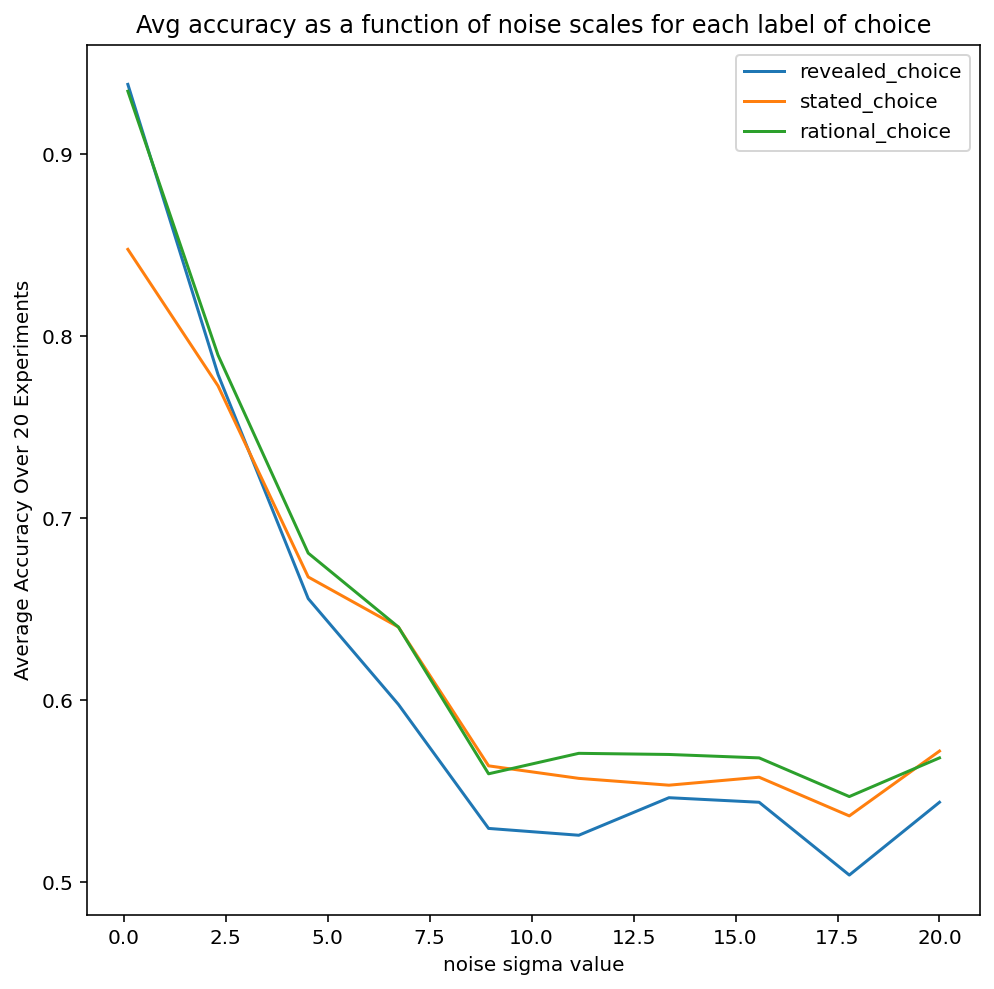

In [ ]:
noise_scale_vec = np.linspace(0.1,20,10)
task1_n_repetitions = 20
task1_n_users = 20

## YOUR SOLUTION
revealed_accuracies = dict((sigma, None) for sigma in noise_scale_vec)
stated_accuracies = dict((sigma, None) for sigma in noise_scale_vec)
rational_accuracies = dict((sigma, None) for sigma in noise_scale_vec)

for i, curr_sigma in enumerate(noise_scale_vec):
  accum_sigma_acc = {'revealed_choice': 0, 'rational_choice': 0, 'stated_choice': 0}
  for i in range(task1_n_repetitions):
    # generate and split the dataset to train and validation sets for the current sigma vale(!):
    example_noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=curr_sigma)
    example_train_df, example_eval_df = example_noisy_choice_env.generate_train_eval_datasets(n_users=task1_n_users)
    
    ### fit and predict the logistic regression model for all three labels:
    revealed_model = sklearn.linear_model.LogisticRegression().fit(
      X=example_train_df[example_noisy_choice_env.get_feature_columns()],
      y=example_train_df['revealed_choice'],
    )
    X_revealed_val = example_eval_df[example_noisy_choice_env.get_feature_columns()]
    y_revealed_val = example_eval_df['revealed_choice']


    rational_model = sklearn.linear_model.LogisticRegression().fit(
      X=example_train_df[example_noisy_choice_env.get_feature_columns()],
      y=example_train_df['rational_choice'],
    )
    X_rational_val = example_eval_df[example_noisy_choice_env.get_feature_columns()]
    y_rational_val = example_eval_df['rational_choice']

    stated_model = sklearn.linear_model.LogisticRegression().fit(
      X=example_train_df[example_noisy_choice_env.get_feature_columns()],
      y=example_train_df['stated_choice'],
    )
    X_stated_val = example_eval_df[example_noisy_choice_env.get_feature_columns()]
    y_stated_val = example_eval_df['stated_choice']
    
    ###

    accum_sigma_acc['revealed_choice'] += revealed_model.score(X_revealed_val, y_revealed_val)
    accum_sigma_acc['stated_choice'] += stated_model.score(X_stated_val, y_revealed_val)
    accum_sigma_acc['rational_choice'] += rational_model.score(X_rational_val, y_revealed_val)
  
  revealed_accuracies[curr_sigma] = accum_sigma_acc['revealed_choice'] / task1_n_repetitions
  stated_accuracies[curr_sigma] = accum_sigma_acc['stated_choice'] / task1_n_repetitions
  rational_accuracies[curr_sigma] = accum_sigma_acc['rational_choice'] / task1_n_repetitions


fig, ax = plt.subplots(1,1, figsize= (8,8))
ax.plot(noise_scale_vec, list(revealed_accuracies.values()), label='revealed_choice')
ax.plot(noise_scale_vec, list(stated_accuracies.values()), label='stated_choice')
ax.plot(noise_scale_vec, list(rational_accuracies.values()), label='rational_choice')
ax.set_title('Avg accuracy as a function of noise scales for each label of choice')
ax.set_xlabel('noise sigma value')
ax.set_ylabel('Average Accuracy Over 20 Experiments')
ax.legend();




Explain the results in detail. In your answer, relate to:
* Overall trends: 
  * Are the lines increasing/decreasing/constant as a function of $\sigma$? Why?
* Relation between the lines: 
  * Assuming that $y_\mathrm{rational}$ can't be measured in practice - Which of the other methods is better when $\sigma\to 0$? which method is better when $\sigma\to \infty$? 
  * If lines cross each other, when and why do they cross? 
  * If lines coincide, when and why do they coincide?
* Range of values: 
  * What is the range of accuracy values obtained? 
  * How do they relate to upper/lower bounds of predictive performance?



🔵 **Answer**:

(YOUR SOLUTION)

*Overall trends*:

As expected, the lines are decreasing as a function of  $\sigma$. This occurs because greater sigma values cause higher variance. This makes it harder for the rational, revealed and stated choices of the evaluation to act in accordance with the revealed values of the evaluation set (need to be simultaneously smaller or greater than 0).

*Relation between the lines:*

when $\sigma\to 0$: we get that (revealed value)~(rational value). Making them almost completely accurate predictions on the real value ($y_\mathrm{rational}$).
lines who cross/coincide with each other: we notice that the revealed_choice and rational_choice never cross each other. As expected, the rational_choice is always better (the random choice has no fixed pattern, which makes it harder to predict when our prediction is noisy as well). In addtion, the stated choice graph for $\sigma\to 0$ is worse than the revealed choice because in this scenario, the revealed choice is almost the rational choice, which makes the trained model to fit almost perfectly to the evaluation's true labels. But for other sigma values, the stated_choice is more accurate compared to the revealed_choice because it has a fixed additive pattern (bias) that is smaller than $\sigma$ which causes the model to fit a line that represents a tilted rational choice prediction, but less tilted than and variant compared to the revealed choice values. The stated choice also cross the rational choice model for some $\sigma$ values because the noise spreads the points in a way that sometimes more points fall correctly (when noise is applied) on thier correct predction in the stated values' model (but since it's random, it overperforms/underperforms only by a small margin for $\sigma$'s far from 0)

*Range of values:*

range of accuracy values obtained: ~100% - ~50%
The upper bound is obvious. The lower bound represents an average random model for binary classificaiton.

## Exercise 1.3: Evaluating Welfare

Plot a similar graph for the welfare metric you created in HW1:

$$
\mathrm{welfare}(f, S)=\frac{1}{|S|}\sum_{ (u,x) \in S } f(x) v_u(x)
$$

🔵 **Answer**:

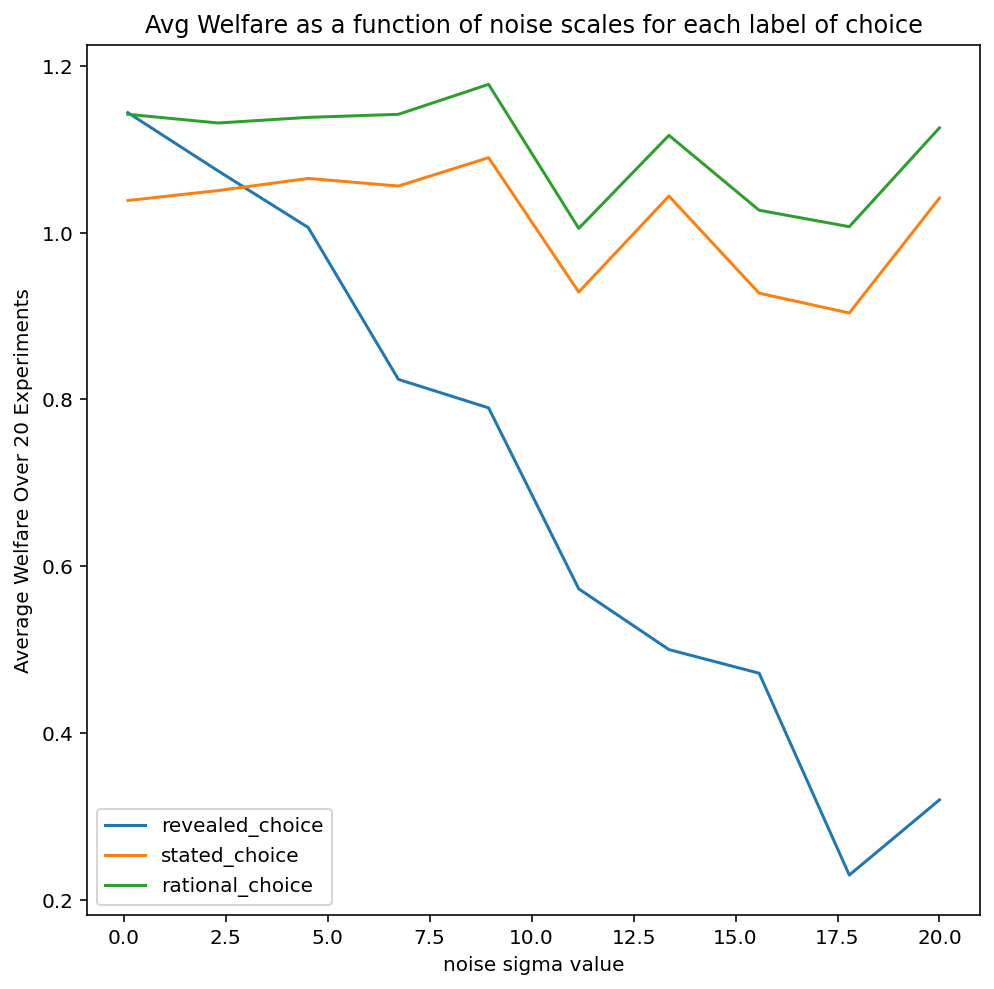

In [ ]:

## YOUR SOLUTION
def welfare(f, eval_df, feature_columns, value_column):
    """
    Calculate the welfare for the given evaluation set
    
    Parameters
    ----------
    f : prediction function from pandas dataframe to {0,1}
    eval_df : pandas DataFrame, as returned by env.generate_train_eval_datasets
    feature_columns : names of feature columns (e.g `env.get_feature_columns()`)
    value_column : name of value column (e.g `true_value`)

    Output
    ------
    welfare : float
    """
  
    prod = f(eval_df[feature_columns]) @ eval_df[value_column]
    welfare = (np.sum(prod)) / (len(eval_df))

    return welfare

noise_scale_vec = np.linspace(0.1,20,10)
task1_n_repetitions = 20
task1_n_users = 20

## YOUR SOLUTION
revealed_welfare = dict((sigma, None) for sigma in noise_scale_vec)
stated_welfare = dict((sigma, None) for sigma in noise_scale_vec)
rational_welfare = dict((sigma, None) for sigma in noise_scale_vec)

for i, curr_sigma in enumerate(noise_scale_vec):
  accum_welfare = {'revealed_choice': 0, 'rational_choice': 0, 'stated_choice': 0}
  for i in range(task1_n_repetitions):
    # generate and split the dataset to train and validation sets for the current sigma vale(!):
    example_noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=curr_sigma)
    example_train_df, example_eval_df = example_noisy_choice_env.generate_train_eval_datasets(n_users=task1_n_users)
    
    ### fit and predict the logistic regression model for all three labels:
    revealed_model = sklearn.linear_model.LogisticRegression().fit(
      X=example_train_df[example_noisy_choice_env.get_feature_columns()],
      y=example_train_df['revealed_choice'],
    )

    rational_model = sklearn.linear_model.LogisticRegression().fit(
      X=example_train_df[example_noisy_choice_env.get_feature_columns()],
      y=example_train_df['rational_choice'],
    )

    stated_model = sklearn.linear_model.LogisticRegression().fit(
      X=example_train_df[example_noisy_choice_env.get_feature_columns()],
      y=example_train_df['stated_choice'],
    )

    
    ###
    
    accum_welfare['revealed_choice'] += welfare(revealed_model.predict, example_eval_df, example_noisy_choice_env.get_feature_columns(), 'true_value')
    accum_welfare['stated_choice'] += welfare(stated_model.predict, example_eval_df, example_noisy_choice_env.get_feature_columns(), 'true_value')
    accum_welfare['rational_choice'] += welfare(rational_model.predict, example_eval_df, example_noisy_choice_env.get_feature_columns(), 'true_value')
  
  revealed_welfare[curr_sigma] = accum_welfare['revealed_choice'] / task1_n_repetitions
  stated_welfare[curr_sigma] = accum_welfare['stated_choice'] / task1_n_repetitions
  rational_welfare[curr_sigma] = accum_welfare['rational_choice'] / task1_n_repetitions


fig, ax = plt.subplots(1,1, figsize= (8,8))
ax.plot(noise_scale_vec, list(revealed_welfare.values()), label='revealed_choice')
ax.plot(noise_scale_vec, list(stated_welfare.values()), label='stated_choice')
ax.plot(noise_scale_vec, list(rational_welfare.values()), label='rational_choice')
ax.set_title('Avg Welfare as a function of noise scales for each label of choice')
ax.set_xlabel('noise sigma value')
ax.set_ylabel('Average Welfare Over 20 Experiments')
ax.legend();



Explain your results:

🔵 **Answer**:

(YOUR SOLUTION)

1. Remember, our prediction outputs a straight line, so the additive bias to the stated values make roughly the same number of points to be worngly classified each round, but the linear line will be similar. That explains the (approximately) constant gap between the stated and the rational choices.

2. Unsurprisngly, the rational choice gives the highest welfare because it best fits the evaluation model (no manipulation was done on the true values and the evaluation model is sampled iid). Meaning, it will consider more points with positive values and less of negative values compared to the other models.

3. The sigma values do not affect the stated and rational choices because neither of the traning samples' true values were affected by sigma. The variation of welfare values we see for these choices is due to a different split of the training / evaluation datasets and the randomness of the fitting process to the data.

4. The revealed choice model was trained on noisy true values which made the linear regresor fit the data poorly and consider negative values + not consider positive values. The bigger the sigma of the noise is, the worst is our welfare (negative values can be wrongly predicted to be bought, and higher positive values can be wrongly predicted to not be bought). For this reason it yields the worst performance.

## Exercise 1.4: Welfare counter-example

**Assuming we use a linear classifer** (i.e. $y = \mathrm{sign}(w^Tx + b)$)

Find a dataset for which the classifier which yields the best accuracy, does not promote optimal welfare. Explain your answer.

In your answer, you should provide:
* Items and features
* Utility function (utility doen't have to be linear)
* Present a classifier, and explain why it's optimal in terms of accuracy.
* Present another classifier which may have worse accuracy but better welfare.

Note: you can sketch a 1D/2D dataset using Power-Point (taking a screenshot), or through this website: https://app.diagrams.net/. Describe the solution in words below. 

Attach the diagram inside a zip file together with your notebook when you submit your solution.

🔵 **Answer**:
in the attached diagram: 
5 items, 2 features for each item such that the dataset is not linearly separable. 

since the dataset is not linearly separable, we cannot get a 100% accuracy by any linear model. 

model(I): it misclassifies only point C, thus achives a 80% accuracy which is the maximum accuracy that can be achieved by a linear model on a 5 point non separable dataset. while the welfare of this model is 0 - because it predicts a false choice for all the points. 

model(II): it misclassifies D and E, thus achives a 60% accuracy. 
the welfare of this model 33 - the sum of the utilities of CDE. 


(YOUR SOLUTION)

## Exercise 1.5: Exploratory Analysis (Open-Ended)


Looking at both measures (accuracy and welfare), try to vary the parameters of the experiment (\#users, \#items, \#features, etc.) in ways that show interesting trends. Explain your results in detail and support your claims.

🔵 **Answer**:

In [ ]:
## YOUR SOLUTION

Explain your results:

🔵 **Answer**:

(YOUR SOLUTION)

# Task \#2: Rationality assumptions in loss-averse environments

## Introduction

In this task, we will evaluate the performance of a standard ("rational") prediction model when decision-makers are loss-averse. 

In this section, users make decisions under uncertainty. Each user has two inherent utility functions, $u_a$ and $u_b$, and a probability parameter $p\in\left[0,1\right]$. The user's utility from consuming an item $x$ is:
- $u_a(x)\in\mathbb{R}$ with probability $p$, and 
- $u_b(x)\in\mathbb{R}$ with probability $(1-p)$. 

When user behavior is *rational*, the decision is made by comparing the *expected utility* of the two alternatives:

$$
y_\text{rational}=\begin{cases}
1&p \cdot u_a(x) + (1-p) \cdot u_b(x) \ge 0\\
0&\text{otherwise}
\end{cases}
$$

When user decisions are subject to *behavioral bias*, choice deviates from the expected optiumum. In particular, we will focus on a setting where the users are *loss-averse*. In the spirit of Prospect Theory [[1](https://en.wikipedia.org/wiki/Prospect_theory)], we assume there exist two functions $\pi, v$ such that the perceived value from consuming the item is:

$$
\begin{align}
V_{\pi, v}\left(x\right)
&=\sum_{i=1}^2 \pi\left(p_i\right) v\left(u_i(x)\right)\\
&=\pi(p) \cdot v(u_a(x)) + \pi(1-p) \cdot v(u_b(x))
\end{align}
$$

The function $v$ captures the loss-aversion property, and it is s-shaped and asymmetrical. The function $\pi$ is a probability weighting function and captures the idea that people tend to overreact to small probability events, but underreact to large probabilities. Assuming $v(0)=0$, consumption decisions are made according to the following rule:

$$
y_\text{prospect}=\begin{cases}
1&V_{\pi,v}(x) \ge 0\\
0&\text{otherwise}
\end{cases}
$$

## Exercise 2.1: Understanding the functional form of $v$


The user valuation bias can be modeled using an S-shaped assymetrical function $v:\mathbb{R}\to\mathbb{R}$. Following [[2](https://www.econstor.eu/bitstream/10419/87132/1/472515071.pdf)], we assume that $v$ is a power S-shaped utility function, and its functional form is given by:


$$
v(u)=\begin{cases}
u^\alpha& u \ge 0 \\
-\gamma \left(-u\right)^\beta& u < 0
\end{cases}
$$

where $u=u(x)$ is the objective utility from consuming item $x$, and $0< \alpha \le \beta \le 1$, $\gamma\ge 1$ are constants.


**Implementation**

Implement the class `PowerLossAversion`. The class constructor will receive three scalar constants `alpha`, `beta`, `gamma`.  The `__call__` function will calculate $v(u)$ as defined above.

Hint: Make your code more efficient by using numpy vectorized operations, and avoid explicit loops and if statements.

🔵 **Answer**:

In [ ]:
class PowerLossAversion:
    """
    The power S-shaped utility function, as defined by Maggi (2014)
    """
    def __init__(self, alpha, beta, gamma):
        assert 0 < alpha <= 1
        assert 0 < beta <= 1
        assert alpha <= beta
        assert gamma >= 1
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
    
    def __call__(self, u):
        """
        Compute the power S-shaped utility function for a vector of utilities.

        Parameters
        ----------
        u : ndarray of shape (n)

        Output
        ------
        v : ndarray of shape (n)
        """
        ## YOUR SOLUTION
        return [u_i**self.alpha if u_i>=0 else -1 * self.gamma * ((-1* u_i)**self.beta) for u_i in u]

Using the implementation above, plot the function $\nu$ for values of $u$ in the range $[-2,2]$, and for the given sets of parameters:

  1. $\left(\alpha_1, \beta_1, \gamma_1\right) = \left(1, 1, 1\right)$
  2. $\left(\alpha_2, \beta_2, \gamma_2\right) = \left(1, 1, 2.5\right)$
  3. $\left(\alpha_3, \beta_3, \gamma_3\right) = \left(0.88, 0.88, 2.5\right)$
  4. $\left(\alpha_4, \beta_4, \gamma_4\right) = \left(0.2, 0.88, 1.8\right)$

🔵 **Answer**:

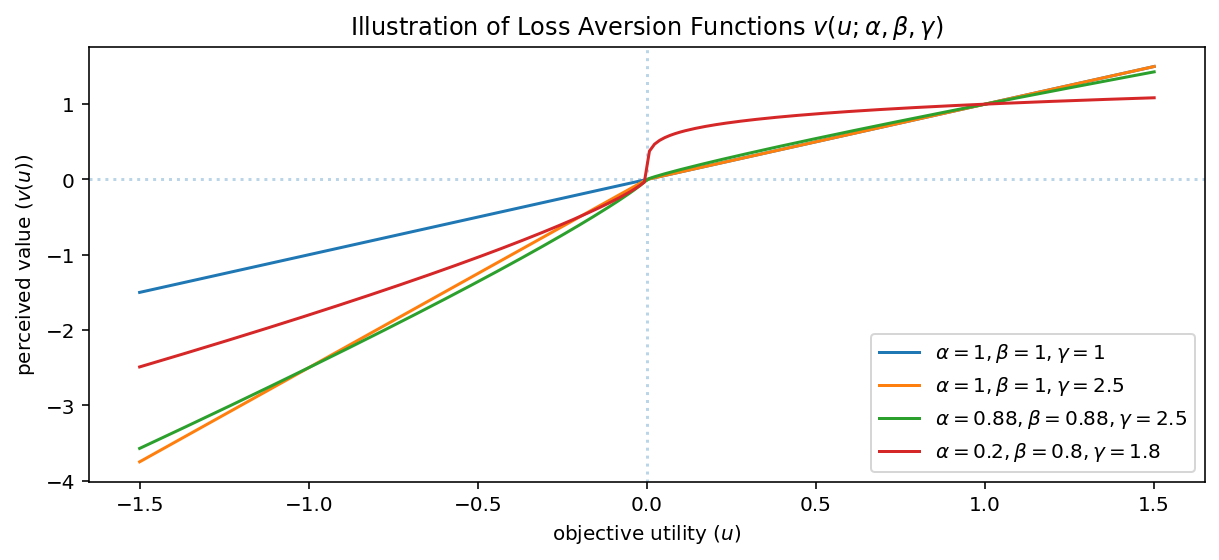

In [ ]:
prospect_params_lst = [
    (1,1,1),
    (1,1,2.5),
    (0.88,0.88,2.5),
    (0.2,0.8,1.8),
]

fig,ax = plt.subplots(figsize=(10,4))

u_vec = np.linspace(-1.5,1.5,200)
for alpha, beta, gamma in prospect_params_lst:
    v = PowerLossAversion(alpha, beta, gamma)
    perceived_value = v(u_vec)
    ax.plot(
        u_vec,
        perceived_value,
        label=f'$\\alpha={alpha}, \\beta={beta}, \\gamma={gamma}$',
    )

ax.set_title('Illustration of Loss Aversion Functions $v(u; \\alpha, \\beta, \\gamma)$')
ax.set_xlabel('objective utility ($u$)')
ax.set_ylabel(r'perceived value ($v(u)$)')
ax.axhline(0,linestyle=':',zorder=-1,alpha=0.3)
ax.axvline(0,linestyle=':',zorder=-1,alpha=0.3)
ax.legend()


Given the results - 

What type of behavior is characterized by the curve parametrized by $\left(\alpha, \beta, \gamma\right) = \left(1, 1, 1\right)$?

🔵 **Answer**:

(YOUR SOLUTION)

It represents the rational behavior. Meaning, we get the same steady increase in utility as the value grows. 



What is the interpretation of the parameter $\gamma$? Which behavioral traits are represented by high/low values of $\gamma$? What aspect of prospect theory does it correspond to?

🔵 **Answer**:

(YOUR SOLUTION)

1. Higher $\gamma$ - negative values become of higher utility decrease (harder to lose) -> fast convergance of the utility to -infinity -> **more loss aversion**
2. Lower $\gamma$ - negative values become of less utility decrease -> slow convergance of the utility to -infinity & user is closer to rationality regarding the loss -> **less loss aversion**
2. Loss aversion - $\gamma$ affects only the negative values, which gives us control in making the sensacion of losing stronger compared to gaining the same value, just like the conecpt of loss aversion suggests.

What is the meaning of the parameters $\alpha,\beta$? What aspects of prospect theory do they correspond to?

🔵 **Answer**:

(YOUR SOLUTION)

Diminishing: alpha is less or equal to beta, which demonstrates the assimetry these parameters provide to make the user valuation bias function diminishing in the utility gain/loss as the values of winning/losing become larger, which corresponds to the diminishing concept.

## Exercise 2.2: Simulating user behavior

**Example**

For the implementation of this behavioral model, we inherit from the `InnerProductTrueValueEnvironment` defined at the start of this notebook, and define the following abstract class:



In [ ]:
class ProspectEnvironment(InnerProductTrueValueEnvironment):
    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        """
        return np.stack(
            [
                np.random.normal(
                    loc=1,
                    scale=0.1,
                    size=(n_users, self.n_features),
                ),
                np.random.normal(
                    loc=-0.1,
                    scale=0.1,
                    size=(n_users, self.n_features),
                ),
            ],
            axis=0,
        )

We can inherit from these classes to create specific behavioral models. For example, here is a class which models unbiased decision making:

In [ ]:
class RationalProspectEnvironmentExample(ProspectEnvironment):
    def __init__(self):
        p_a = np.random.uniform(0,1)
        self.p = [p_a, 1-p_a]
        super().__init__()

    def _choice(self, users, items):
        """
        Simulate choice

        Parameters
        ----------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        items : ndarray of shape (n_users, n_observations, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        # Calculate true value based on inner product
        u_a = self._true_value(users[0], items)
        print(f'shape of u_a : {u_a.shape}')
        u_b = self._true_value(users[1], items)
        return {
            'u_a': u_a,  # u_a(x)
            'u_b': u_b,  # u_b(x)
            'rational_choice': self.p[0]*u_a + self.p[1]*u_b >= 0,
        }

rational_env_example = RationalProspectEnvironmentExample()
rational_train_df, rational_eval_df = rational_env_example.generate_train_eval_datasets(n_users=100)
rational_train_df.sample(5)

shape of u_a : (60, 10)
shape of u_a : (40, 10)


,user_id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,u_a,u_b,rational_choice
162,16,1.008709,0.528037,0.300184,-1.017751,-0.941248,-1.491707,-0.983442,-1.606795,-4.314483,0.460251,False
313,31,-0.366083,0.964079,0.521935,0.074074,0.743795,0.423227,1.608048,-1.043604,2.882929,-0.418238,True
244,24,-0.952948,-1.419614,0.486909,-0.048979,0.143154,1.471321,0.380607,-0.631291,-0.492284,0.021737,False
175,17,-0.596142,-0.697450,0.745121,0.211182,-0.417777,-0.466319,0.182362,1.018205,0.058117,0.051272,True
452,45,-1.488254,-0.264423,-0.718927,-0.636858,0.409235,0.510829,-2.103482,-0.748784,-4.788540,0.768840,False


**Implementation**

Based on the example above, implement the `BehavioralProspectEnvironment` class for simulating choice in a behavioral environment:
* Class should inherit from `ProspectEnvironment`
* Prospect value function $v(u)$ and a probability weighting function $\pi(p)$ should be given in the class constructor.
* Generate the probability $p$ uniformly in $[0, 1]$.
* Implement the binary choice inside the `_choice` function. Function returns a dictionary mapping column names to numpy arrays containing their contents (see example above).

🔵 **Answer**:

In [ ]:
## YOUR SOLUTION
class BehavioralProspectEnvironment(ProspectEnvironment):
    def __init__(self, f_val, f_pi, p = 0.3):
        p_a = p
        self.p = [p_a, 1-p_a]
        self.f_pi = f_pi
        self.f_val = f_val
        super().__init__()

    def _choice(self, users, items):
        """
        Simulate choice

        Parameters
        ----------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        items : ndarray of shape (n_users, n_observations, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        # Calculate true value based on inner product
        u_a = self._true_value(users[0], items)
        u_b = self._true_value(users[1], items)

        return {
            'behavioral_bias_u_a':u_a,
            'behavioral_bias_u_b':u_b,
            'behavioral_bias_choice': np.array([self.f_pi(self.p[0])*np.array(self.f_val(u_a_i)) 
                                  + self.f_pi(self.p[1])*np.array(self.f_val(u_b_i)) >= 0 
                                  for (u_a_i, u_b_i) in zip(u_a, u_b)])
    
        }


### Test for correctness:
# alpha = 0.88

# beta = 0.88
# gamma = 2.5
f_val = PowerLossAversion(alpha, beta, gamma)

def f_pi(u):
  return u+0.1 if u<0.1 else u

# rational_env_example = BehavioralProspectEnvironment(f_val, f_pi)
# users = rational_env_example._generate_user_attributes(2)
# items = rational_env_example._generate_item_attributes(2)
# choice_dict = rational_env_example._choice(users, items)

# print(choice_dict)
# rational_train_df, rational_eval_df = rational_env_example.generate_train_eval_datasets(n_users=100)
# rational_train_df.sample(5)


behavioral_env_example = BehavioralProspectEnvironment(f_val, f_pi)
rational_train_df, rational_eval_df = behavioral_env_example.generate_train_eval_datasets(n_users=100)
rational_train_df.sample(200)

,user_id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,behavioral_bias_u_a,behavioral_bias_u_b,behavioral_bias_choice
509,50,-1.359021,-0.277028,0.690038,-1.289093,1.128536,-0.122084,1.309235,1.048882,1.183728,-0.261714,False
446,44,-1.207688,-0.458509,0.067664,0.680378,-1.296693,-0.166075,1.351199,0.030830,-0.714351,-0.309224,False
96,9,0.111998,1.516679,0.107815,0.995911,0.149421,-1.002622,-0.555696,-0.281324,1.204839,0.123252,True
25,2,-0.887467,-0.095532,0.613504,-0.130284,0.471944,-0.098591,-0.742282,0.278395,-0.171073,0.128255,True
164,16,-1.000206,0.331173,0.163568,0.868854,-0.273819,0.480563,-0.820041,-1.529847,-2.021872,-0.093983,False
...,...,...,...,...,...,...,...,...,...,...,...,...
361,36,1.107020,-0.739215,-1.782089,0.720120,-0.969855,-0.049024,0.678871,-0.647481,-1.270736,0.426529,False
40,4,-0.786843,0.906670,-0.707657,0.792145,-1.040573,-1.572103,1.597297,0.092621,-0.436925,0.086379,True
552,55,0.026747,-2.163410,-0.874876,-0.500016,0.513298,1.512661,0.112313,-0.888994,-2.178288,0.390435,False
139,13,-0.062759,2.074408,-0.059848,-0.662640,-0.007134,-0.617376,0.497193,-2.281515,-1.004382,0.040838,False


## Exercise 2.3: Predicting under behavioral bias



For each set of behavioral parameters $\left(\alpha_1, \beta_1, \gamma_1\right),\dots,\left(\alpha_4, \beta_4, \gamma_4\right)$ given above, and for a neutral probability weighting ($\pi(p)=p$), train and evaluate a Logistic Regression model on data generated by the corresponding `BehavioralProspectEnvironment`, with `n_users=100`.

Report evaluation set accuracy for each set of parameters, averaged over 10 repetitions of the simulation.
`
🔵 **Answer**:

In [ ]:
task_2_3_n_repetitions = 10
task_2_3_n_users = 100

prospect_params_lst = [
  (1,1,1),
  (1,1,2.5),
  (0.88,0.88,2.5),
  (0.2,0.8,1.8),
]
f_val = PowerLossAversion(alpha, beta, gamma)

def f_pi(p):
  return p

avg_accuracies = dict((params, []) for params in prospect_params_lst)

for (alpha, beta, gamma) in prospect_params_lst:
  f_val = PowerLossAversion(alpha, beta, gamma)
  accum_accuracy = [] 
  for i in range(task_2_3_n_repetitions):
    # generate data from BehavioralProspectEnvironment
    behavioral_prospect_env = BehavioralProspectEnvironment(f_val, f_pi)
    behavioral_prosp_train, behavioral_prosp_eval = behavioral_prospect_env.generate_train_eval_datasets(task_2_3_n_users)

    # train a logistic regression model 
    model = sklearn.linear_model.LogisticRegression().fit(
      X=behavioral_prosp_train[behavioral_prospect_env.get_feature_columns()],
      y=behavioral_prosp_train['behavioral_bias_choice'],
    )
    accum_accuracy.append(model.score( 
      X=behavioral_prosp_eval[behavioral_prospect_env.get_feature_columns()],
      y=behavioral_prosp_eval['behavioral_bias_choice']))
  avg_accuracies[(alpha, beta, gamma)].append(np.mean(accum_accuracy))

print(avg_accuracies)




{(1, 1, 1): [0.9019999999999999], (1, 1, 2.5): [0.812], (0.88, 0.88, 2.5): [0.7657499999999999], (0.2, 0.8, 1.8): [0.636]}


Plot a line graph representing the accuracy, for fixed $\alpha=\beta=1$ and variable $\gamma\in[1,15]$. Repeat each simulation 10 times for each value of $\gamma$, and use the average value for the plot.

🔵 **Answer**:

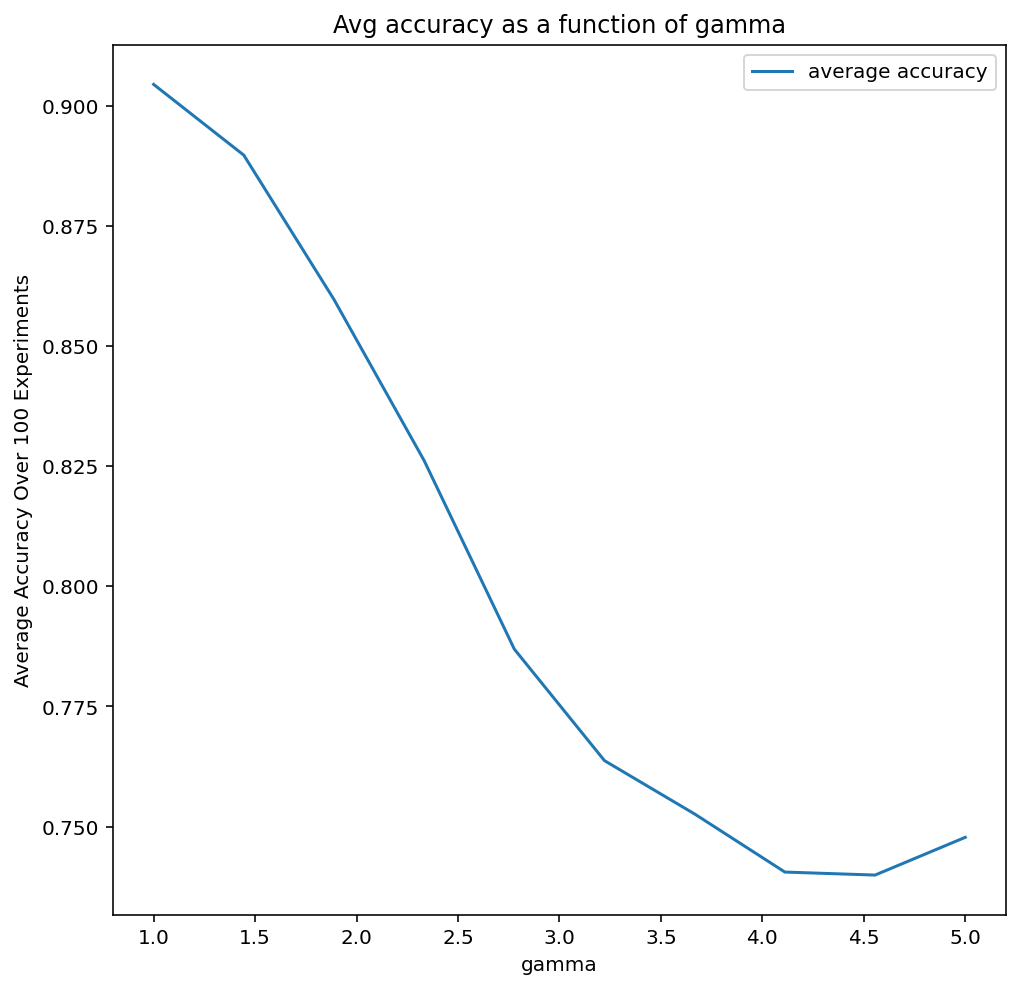

In [ ]:
alpha = 1
beta = 1
gamma_vec = np.linspace(1,5,10)
num_rep = 100
avg_accuracies = []
for gamma in gamma_vec: 
    f_val = PowerLossAversion(1, 1, gamma)
    accum_accuracy = []
    for i in range(num_rep): 
        # generate data from BehavioralProspectEnvironment
        behavioral_prospect_env = BehavioralProspectEnvironment(f_val, f_pi)
        behavioral_prosp_train, behavioral_prosp_eval = behavioral_prospect_env.generate_train_eval_datasets(task_2_3_n_users)
         # train a logistic regression model 
        model = sklearn.linear_model.LogisticRegression().fit(
          X=behavioral_prosp_train[behavioral_prospect_env.get_feature_columns()],
          y=behavioral_prosp_train['behavioral_bias_choice'],
        )
        accum_accuracy.append(model.score( 
          X=behavioral_prosp_eval[behavioral_prospect_env.get_feature_columns()],
          y=behavioral_prosp_eval['behavioral_bias_choice'])
        )
    avg_accuracies.append(np.mean(accum_accuracy))
fig, ax = plt.subplots(1,1, figsize= (8,8))
ax.plot(gamma_vec, avg_accuracies, label='average accuracy')
ax.set_title('Avg accuracy as a function of gamma')
ax.set_xlabel('gamma')
ax.set_ylabel('Average Accuracy Over 100 Experiments')
ax.legend();
    

Explain the results: 

🔵 **Answer**:

we can see that as gamma grows, the accuracy of the model decreases. 
this trend makes sense because as gamma grows, the generated data presents more loss-averse users - i.e users experience loss harder as gamma grows. hence, when gamma grows above 1 the utility function diverges from the linear identity function, which makes it harder for a linear model to predict. Remember, logistic regression assumes a linear score function and predicts by thresholding this linear score, this assumption become invalid as gamma grows.  

Similarly, plot two lines representing the accuracy, for fixed $\gamma=\{1,2\}$ and variable $\alpha=\beta\in[0.5,1]$. Repeat each simulation 10 times for each value of $\gamma$, and average results.

🔵 **Answer**:

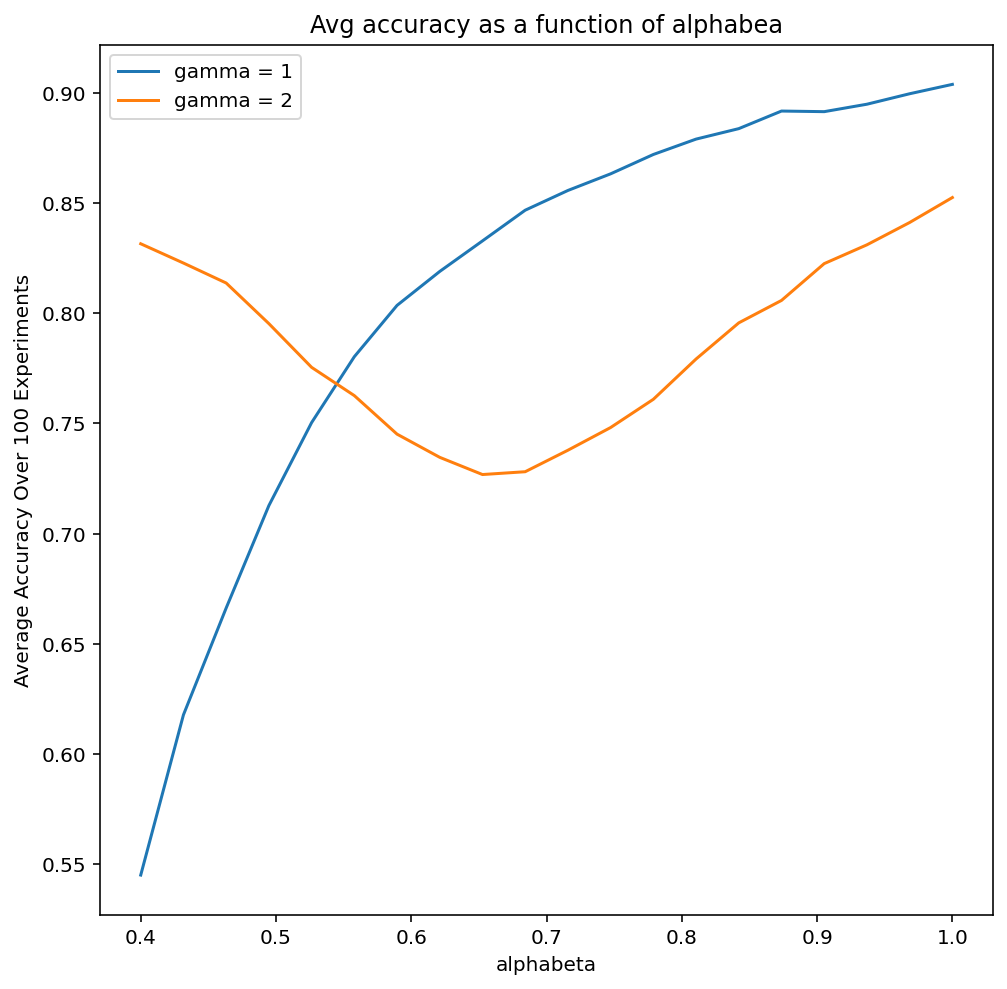

In [ ]:
alphabeta_vec = np.linspace(0.4,1,20)
gamma=[1,2]

## YOUR SOLUTION
num_rep = 100

avg_accuracies = dict((f'gamma_{g}' ,[]) for g in gamma)

for g in gamma:
    for alphabeta in alphabeta_vec: 
        f_val = PowerLossAversion(alphabeta, alphabeta, g)
        accum_accuracy = []
        for i in range(num_rep): 
            # generate data from BehavioralProspectEnvironment
            behavioral_prospect_env = BehavioralProspectEnvironment(f_val, f_pi)
            behavioral_prosp_train, behavioral_prosp_eval = behavioral_prospect_env.generate_train_eval_datasets(task_2_3_n_users)
             # train a logistic regression model 
            model = sklearn.linear_model.LogisticRegression().fit(
              X=behavioral_prosp_train[behavioral_prospect_env.get_feature_columns()],
              y=behavioral_prosp_train['behavioral_bias_choice'],
            )
            accum_accuracy.append(model.score( 
              X=behavioral_prosp_eval[behavioral_prospect_env.get_feature_columns()],
              y=behavioral_prosp_eval['behavioral_bias_choice']))
        avg_accuracies[f'gamma_{g}'].append(np.mean(accum_accuracy))

fig, ax = plt.subplots(1,1, figsize= (8,8))
ax.plot(alphabeta_vec, avg_accuracies['gamma_1'], label='gamma = 1')
ax.plot(alphabeta_vec,avg_accuracies['gamma_2'], label='gamma = 2')
ax.set_title('Avg accuracy as a function of alphabea')
ax.set_xlabel('alphabeta')
ax.set_ylabel('Average Accuracy Over 100 Experiments')
ax.legend();
    

Explain your results: 

🔵 **Answer**:
for gamma  = 1: 
in this case the utility is s shaped and symetric around y = 0. 
we can see that in this case the accuracy grows with alphabeta. becasue as alphabeta grows, the utility becomes more similar to linear utility. since logistic regression assumes a linear score function  -i.e utility function - when utility goes closer to linear, the model assumption becomes more valid which yields better results. 

for gamma  = 2: 
in this case the utility is s shaped and asymetric around y = 0, with faster convergence in the negative side. 
we can see that the accuracy starts to decrease as alphabeta grows, until some point alphabeat = ~0.7 then starts to increase. 




What can we conclude about the performance of a logistic regression classifier on behavioral data? What can explain the above observations?

🔵 **Answer**:
logistic regression assumes a linear score function  -i.e utility function - and predicts by thresholding this linear utility, this assumption becomes more and more wrong as the utility is loss averted. 


## Exercise 2.4: Exploratory Analysis (Open-Ended)

We present three open-ended questions. Please choose one of them and answer in detail. **Bonus will be given for solving more than one question**.

This task is exploratory, and we encourage you to try different and creative approaches to solve it. In your answers, you should design and run appropriate experiment(s) - state your hypotheses, show plots that support your claim, and explain them.

### Option 1: Alternative probability weighting

Up until now, the decision model we analyzed assumed $\pi$ to be neutral ($\pi(p)=p$). A model with the following $\pi$ is proposed:

$$\pi(p)=(1-p)\cdot\sqrt{p}+p\cdot(1-\sqrt{1-p})
$$

Will this change the accuracy analysis results? If so, how and in which direction? If not, why? Explain, and run experiments to support your claims.

### Option 2: Estimating behavioral deviations

Assuming neutral $\pi$ ($\pi(p)=p$) and a power S-shaped utility function $v$ (as described in Ex. 2.1), propose a way to estimate the functional parameters $\alpha,\beta,\gamma$ from data. Support your claims using simulated data.

### Option 3: Accounting for behavioral deviations

Assuming neutral $\pi$ ($\pi(p)=p$) and a power S-shaped utility function $v$ (as described in Ex. 2.1), significantly improve predictive performance compared to the naive logistic regression baseline. 

Support your claims using simulated data, and evaluate performance on behavioral models with parameters $\alpha, \beta, \gamma$ as defined in `prospect_params_lst` above.
Explain your methods. How did you train your model? Why?


🔵 **Answer**:

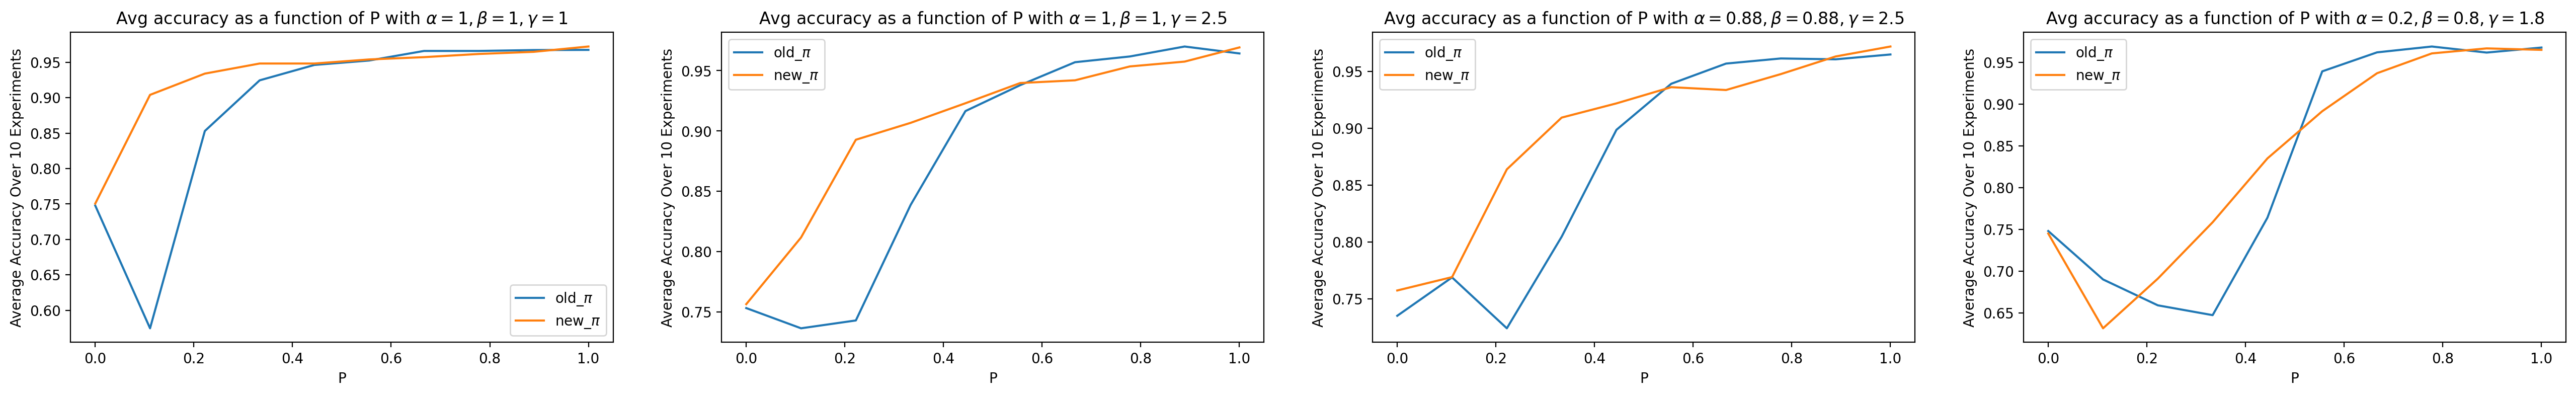

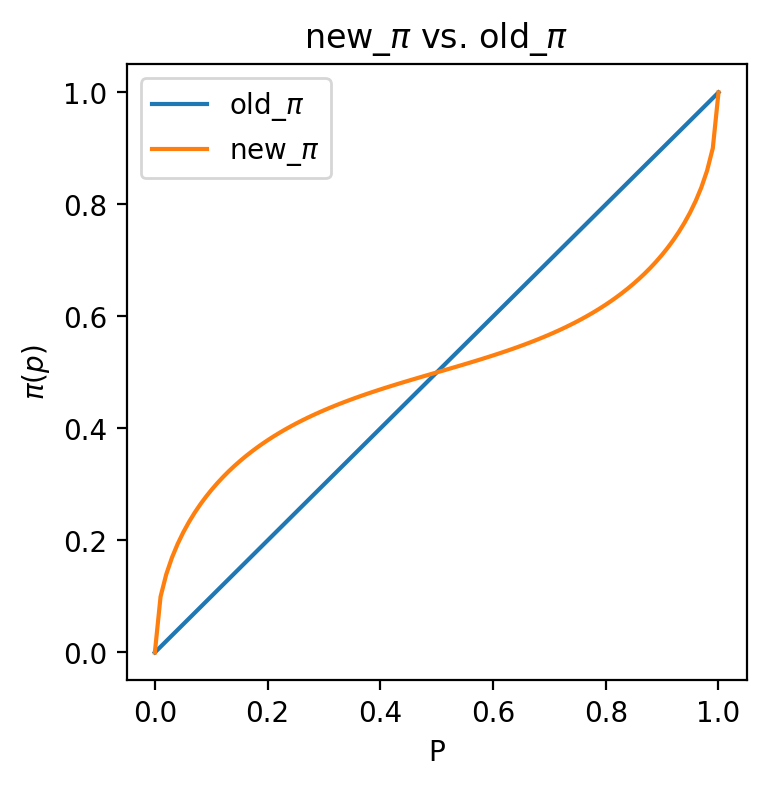

In [ ]:
## YOUR SOLUTION
prospect_params_lst = [
  (1,1,1),
  (1,1,2.5),
  (0.88,0.88,2.5),
  (0.2,0.8,1.8),
]

p_vals = np.linspace(0, 1, 10)


def f_pi_new(p):
  return (1-p)*np.sqrt(p) + p*(1- np.sqrt(1-p))

def f_pi_identity(p):
  return p

def get_pi(identity = True):
    if identity:
      return f_pi_identity
    else:
      return f_pi_new   

avg_accuracies = dict((params, dict((p, None) for p in p_vals )) for params in prospect_params_lst )

fig, ax = plt.subplots(1,len(prospect_params_lst), figsize= (32, 4))

for identity in (True, False):
  for (alpha, beta, gamma) in prospect_params_lst:
    f_val = PowerLossAversion(alpha, beta, gamma)
    for p in p_vals:   
      accum_accuracy = [] 
      for i in range(task_2_3_n_repetitions):
            # generate data from BehavioralProspectEnvironment
        behavioral_prospect_env = BehavioralProspectEnvironment(f_val, get_pi(identity), p)
        behavioral_prosp_train, behavioral_prosp_eval = behavioral_prospect_env.generate_train_eval_datasets(task_2_3_n_users)

        # train a logistic regression model 
        model = sklearn.linear_model.LogisticRegression().fit(
          X=behavioral_prosp_train[behavioral_prospect_env.get_feature_columns()],
          y=behavioral_prosp_train['rational_choice']
        )
        
        accum_accuracy.append(model.score( 
          X=behavioral_prosp_eval[behavioral_prospect_env.get_feature_columns()],
          y=behavioral_prosp_eval['rational_choice']))
      
      avg_accuracies[(alpha, beta, gamma)][p] = np.mean(accum_accuracy)

  for i, (params, accuracies) in enumerate(avg_accuracies.items()):
    ax[i].plot(p_vals, avg_accuracies[params].values(), label='old_$\\pi$' if identity else 'new_$\\pi$')
    ax[i].set_title(f'Avg accuracy as a function of P with $\\alpha = {params[0]}, \\beta = {params[1]}, \\gamma = {params[2]}$')
    ax[i].set_xlabel('P')
    ax[i].set_ylabel('Average Accuracy Over 10 Experiments')
    ax[i].legend();

# plot of the new_pi versus the old pi 
p_space = np.linspace(0,1,100)

fig, ax = plt.subplots(1,1, figsize= (4, 4))
for identity in (True, False):
  percieved_p = get_pi(identity)(u)
  ax.plot(p_space, percieved_p , label='old_$\\pi$' if identity else 'new_$\\pi$')
ax.set_title(f'new_$\\pi$ vs. old_$\\pi$')
ax.set_xlabel('P')
ax.set_ylabel('$\\pi(p)$')
ax.legend();     




Explain your results: 

🔵 **Answer**:

anotation: 
old_pi => $$\pi(p)=p$$
           new_pi => $$\pi(p)=(1-p)\cdot\sqrt{p}+p\cdot(1-\sqrt{1-p})$$

1 - three intersection points between old and new pi functions, for all alpha,beta,gamma combinations  - p = 0, p = 0.5, p = 1
2 - accuracy in p=0, p=1 intersection points are similar for all alpha,beta,gamma combinations
3 - model with new_pi outperforms the old_pi model until p =0.5, then vice versa for p>0.5. same trend for all alpha,beta,gamma combinations
4 - generally, accuracy grows as p grows. for both pi functions and for all alpha,beta,gamma combinations

explanation:
1. mathematically: we get that old_pi(p) = new_pi(p) only for values p = [0, 0.5, 1]. note: the intersections at 0, 0.5,1 are not exact intersections, due to the noise of generating two different environments for the two pi functions.

2. for p = 1, for both old_pi and new_pi, we get the percieved value $v(u_a(x))$. Mathematically, The values of alpha, beta, gamma do not affect the sign of of the percieved value function. since our predictions are based on the sign of the percived value, we expect them not to change as a factor of different alpha, beta, gamma. The same explaination holds for p = 0. 

3. $u_a(x)$ by itself yields the best accuracy. This claim is supported by looking at the accuracies when p=0 (estimation solely based on $u_b(x)$) is ~0.75 and when p=1 (estimation solely based on $u_a(x)$) the accuracy jumps to ~0.95. We'd expect that when giving larger weight (a.k.a probability) to $u_a(x)$, our accuracy will grow. And indeed (based on plot "old_pi vs. new_pi"), until p=0.5, new_pi gave a larger probability to $u_a(x)$ and thus outperformed old_pi. when p>0.5, we see the opposite trend - old_pi yields a better accuracy, also due to the fact that it gives larger probability to $u_a(x) compared to new_pi.

4. again, based on the conclusion that we get better performance when $u_a$ is given more weight and new_pi, old_pi are monotonically increasing, we see that both old and new $\pi$ show better accuracy as $p$ grows